# Outliers detection using AutoEncoders

In [1]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.model_selection import KFold


Using TensorFlow backend.


## Data loading

In [13]:
%run ../util/load_data.py
%run ../util/data_visualization.py
%run ../util/outliers_statistics.py

data = load_data("../data")

train_data_with_outliers = data['train_data'][data['numerical_attributes'] + ['Id']]

## Outliers detection with Auto-Encoders

### Network construction

In [3]:
nb_epoch = 10
batch_size = 128
input_dim = len(data['numerical_attributes']) #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-5

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)



### Outliers detection

In [4]:
kf = KFold(n_splits=10)

outliers_ids = []

for train, test in kf.split(train_data_with_outliers):
    train_data = train_data_with_outliers.iloc[train, :]
    test_data = train_data_with_outliers.iloc[test, :]
    
    
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
    
    autoencoder.fit(train_data.drop("Id", axis=1), train_data.drop("Id", axis=1),
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1)
    
    test_data_predictions = autoencoder.predict(test_data.drop("Id", axis=1))
    
    mse = np.mean(np.power(test_data.drop("Id", axis=1) - test_data_predictions, 2), axis=1)
    mse_mean = np.mean(mse)
    
    prediction_result = zip(
        train_data_with_outliers['Id'].values,
        mse
    )
    
    outliers_ids += [id for id, distance in prediction_result if distance > mse_mean * 1.5]
    
    
    

Epoch 1/10
13608/13608 [==============================] - 1s 38us/step - loss: 1442790.3774 - acc: 0.0619
Epoch 2/10
13608/13608 [==============================] - 0s 20us/step - loss: 1441291.2376 - acc: 0.0410
Epoch 3/10
13608/13608 [==============================] - 0s 19us/step - loss: 1439630.8793 - acc: 0.0309
Epoch 4/10
13608/13608 [==============================] - 0s 20us/step - loss: 1438384.4131 - acc: 0.0309
Epoch 5/10
13608/13608 [==============================] - 0s 22us/step - loss: 1437221.8696 - acc: 0.0309
Epoch 6/10
13608/13608 [==============================] - 0s 21us/step - loss: 1436098.2741 - acc: 0.0309
Epoch 7/10
13608/13608 [==============================] - 0s 23us/step - loss: 1434999.6120 - acc: 0.0309
Epoch 8/10
13608/13608 [==============================] - 0s 21us/step - loss: 1433916.3344 - acc: 0.0309
Epoch 9/10
13608/13608 [==============================] - 0s 17us/step - loss: 1432844.3145 - acc: 0.0309
Epoch 10/10
13608/13608 [=====================

13608/13608 [==============================] - 0s 15us/step - loss: 1506968.3641 - acc: 0.0437
Epoch 8/10
13608/13608 [==============================] - 0s 21us/step - loss: 1505954.2933 - acc: 0.0437
Epoch 9/10
13608/13608 [==============================] - 0s 24us/step - loss: 1504940.8820 - acc: 0.0437
Epoch 10/10
13608/13608 [==============================] - 0s 23us/step - loss: 1503928.1943 - acc: 0.0437
Epoch 1/10
13608/13608 [==============================] - 1s 72us/step - loss: 1604212.1042 - acc: 0.0528
Epoch 2/10
13608/13608 [==============================] - 0s 23us/step - loss: 1603161.3929 - acc: 0.0528
Epoch 3/10
13608/13608 [==============================] - 0s 21us/step - loss: 1602111.4915 - acc: 0.0528
Epoch 4/10
13608/13608 [==============================] - 0s 24us/step - loss: 1601063.5813 - acc: 0.0528
Epoch 5/10
13608/13608 [==============================] - 0s 22us/step - loss: 1600017.4982 - acc: 0.0528
Epoch 6/10
13608/13608 [==============================] 

### Outlier removal

In [5]:
train_data = data['train_data']

data_without_auto_encoders_outliers = train_data[~train_data['Id'].isin(outliers_ids)]
data_without_auto_encoders_outliers.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Type
32,33,2519,102,6,124,4,616,230,233,137,5559,5,8,1
37,38,2511,92,7,182,18,722,231,229,131,5494,5,8,1
47,48,2536,99,6,234,0,659,230,232,136,5475,5,8,1
69,70,2640,80,8,180,-2,1092,231,225,127,5866,2,9,1
84,85,2537,42,7,210,17,1132,222,224,137,4919,2,8,1


# Visualization

##### Create new array of colors with outlier

In [6]:
copy_train_data = data['train_data'][data['numerical_attributes'] + data['target'] + ['Id']].copy()
color = [row[data['target'][0]] if row['Id'] not in outliers_ids else -10 for index,row in copy_train_data.iterrows()]

### PCA Visualization

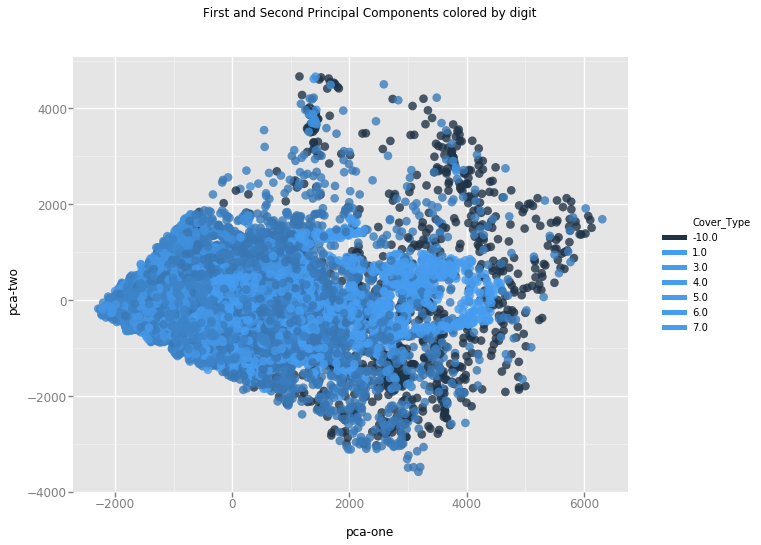

<ggplot: (-9223372036564256775)>

In [7]:
pca_visualization(data['train_data'][data['numerical_attributes'] + data['target']], data['target'][0], color)

### TSNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15120 samples in 0.016s...
[t-SNE] Computed neighbors for 15120 samples in 1.306s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15120
[t-SNE] Computed conditional probabilities for sample 2000 / 15120
[t-SNE] Computed conditional probabilities for sample 3000 / 15120
[t-SNE] Computed conditional probabilities for sample 4000 / 15120
[t-SNE] Computed conditional probabilities for sample 5000 / 15120
[t-SNE] Computed conditional probabilities for sample 6000 / 15120
[t-SNE] Computed conditional probabilities for sample 7000 / 15120
[t-SNE] Computed conditional probabilities for sample 8000 / 15120
[t-SNE] Computed conditional probabilities for sample 9000 / 15120
[t-SNE] Computed conditional probabilities for sample 10000 / 15120
[t-SNE] Computed conditional probabilities for sample 11000 / 15120
[t-SNE] Computed conditional probabilities for sample 12000 / 15120
[t-SNE] Computed conditional probabilities for sa

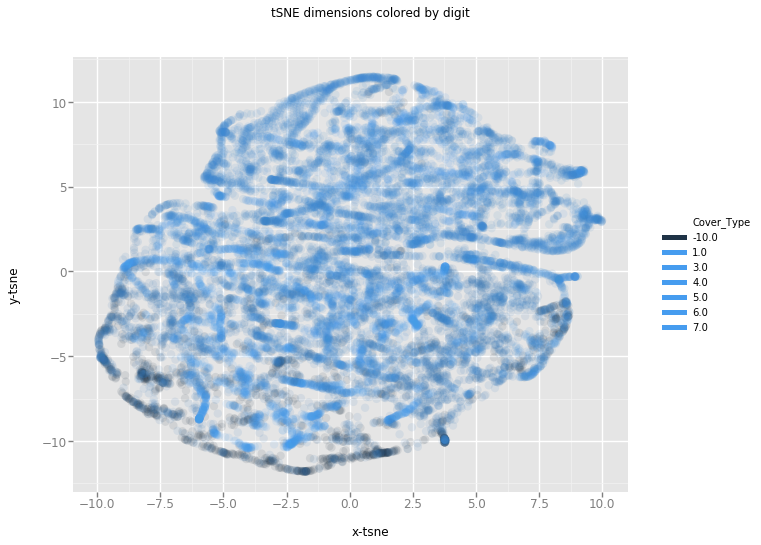

<ggplot: (-9223372036548394103)>

In [8]:
tsne_visualization(data['train_data'][data['numerical_attributes'] + data['target']], data['target'][0], color)

### UMAP

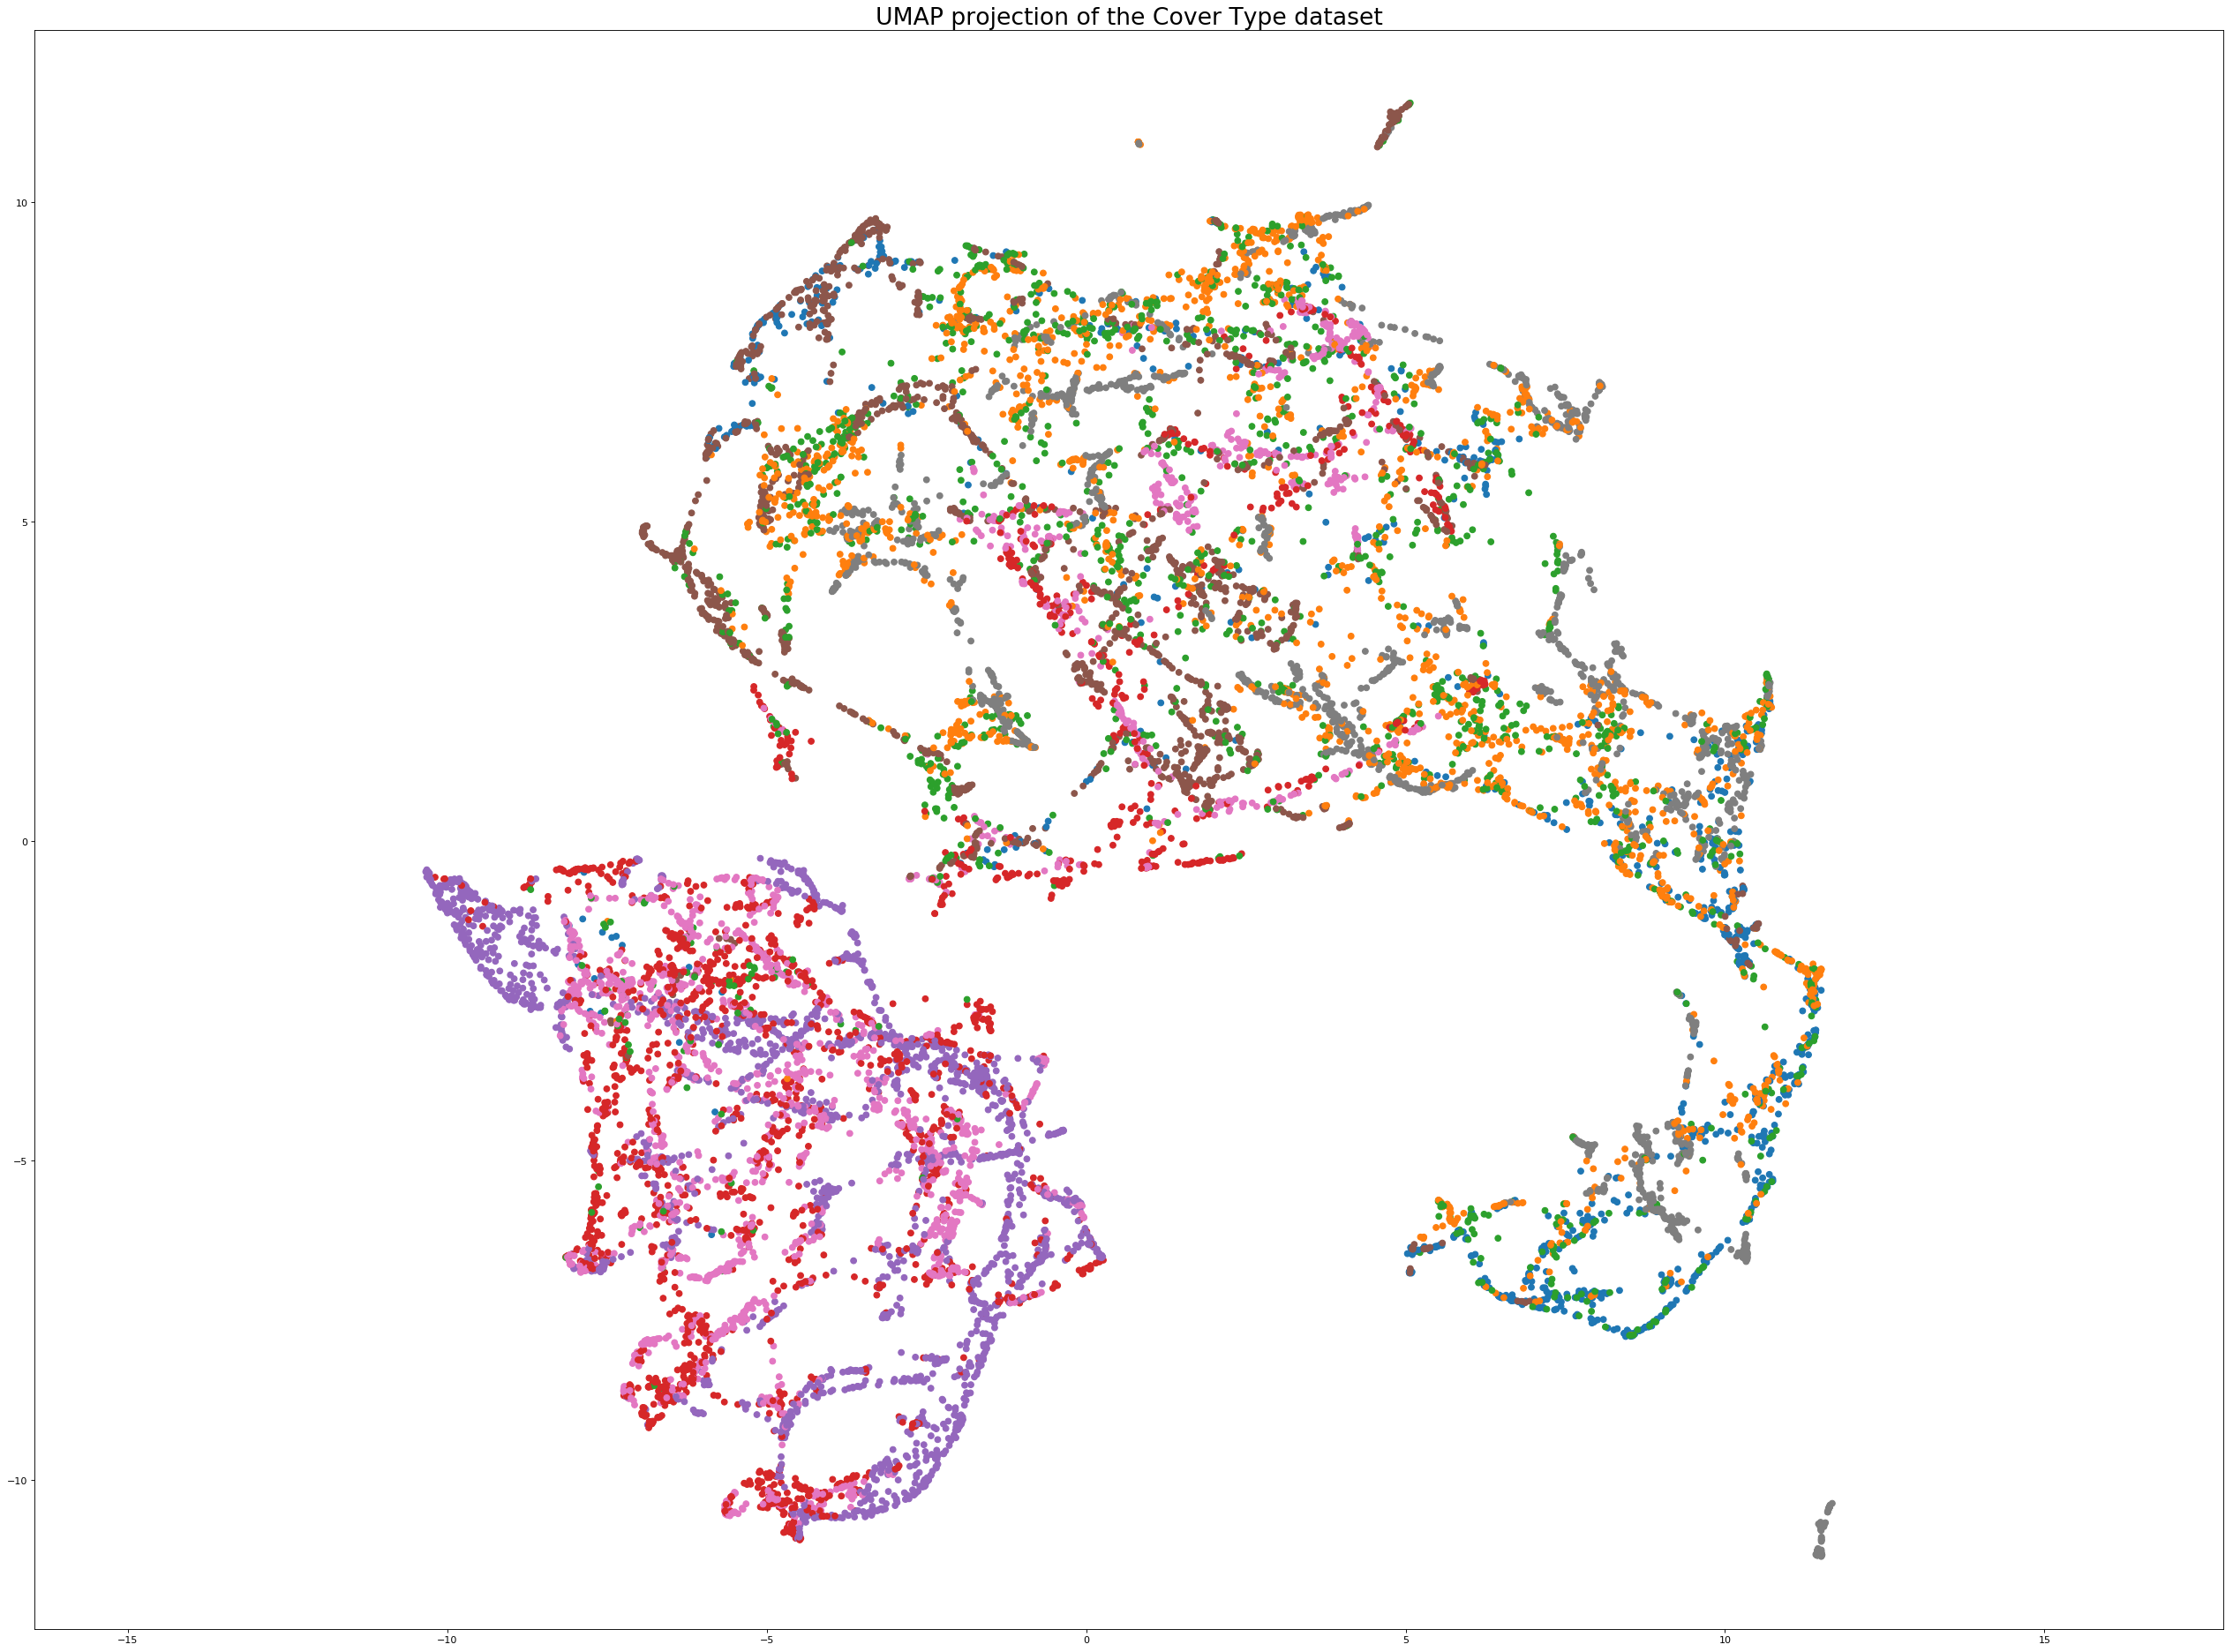

In [9]:
umap_visualization(data['train_data'][data['numerical_attributes'] + data['target']], data['target'][0], color)

In [14]:
precision, recall, F1_score = outliers_statistics(outliers_ids)
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-score: "+ str(F1_score))

Precision: 1
Recall: 0.0
F1-score: 0.0


In [15]:
outliers_ids

[3,
 4,
 12,
 13,
 22,
 23,
 28,
 29,
 30,
 31,
 36,
 37,
 39,
 40,
 41,
 44,
 45,
 51,
 52,
 53,
 56,
 62,
 63,
 68,
 69,
 71,
 72,
 73,
 74,
 76,
 77,
 79,
 80,
 81,
 82,
 83,
 84,
 86,
 87,
 88,
 89,
 90,
 92,
 94,
 95,
 96,
 97,
 98,
 101,
 104,
 107,
 108,
 109,
 111,
 112,
 113,
 114,
 117,
 118,
 120,
 122,
 123,
 124,
 125,
 127,
 131,
 132,
 133,
 134,
 136,
 137,
 138,
 139,
 141,
 142,
 143,
 144,
 145,
 147,
 148,
 149,
 152,
 153,
 155,
 156,
 157,
 158,
 162,
 163,
 167,
 168,
 171,
 173,
 176,
 178,
 179,
 181,
 183,
 184,
 188,
 190,
 192,
 198,
 199,
 201,
 208,
 209,
 212,
 213,
 214,
 220,
 222,
 224,
 225,
 227,
 228,
 229,
 230,
 231,
 233,
 234,
 240,
 244,
 246,
 248,
 249,
 251,
 254,
 255,
 256,
 257,
 259,
 265,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 279,
 280,
 281,
 284,
 290,
 294,
 295,
 296,
 300,
 301,
 302,
 303,
 308,
 309,
 311,
 315,
 319,
 321,
 322,
 325,
 327,
 331,
 332,
 333,
 334,
 337,
 340,
 341,
 342,
 343,
 354,
 355,
 358,
 359,
